# Twitter Hate Speech Detection

# Business Problem

Human content moderation exploits people by consistently traumatizing and underpaying them. In 2019, an [article](https://www.theverge.com/2019/6/19/18681845/facebook-moderator-interviews-video-trauma-ptsd-cognizant-tampa) on The Verge exposed the extensive list of horrific working conditions that employees faced at Cognizant, Facebook’s former moderation contractor. Unfortunately, every major tech company, including Twitter, uses human moderators to some extent, both domestically and overseas.

Hate speech is defined as abusive or threatening speech that expresses prejudice against a particular group, especially on the basis of race, religion or sexual orientation. Usually, the difference between hate speech and offensive language comes down to subtle context or diction. 

Any company with an online forum where users post content could benefit from automating as much as the moderation process as possible. Ultimately, human content moderation is not only detrimental to workers, but also presents a liability to companies that use them.

**Warning:** This notebook contains offensive language from the dataset.

# Data & Methods

The dataset for this capstone project was sourced from a study called *Automated Hate Speech Detection and the Problem of Offensive Language* conducted by Thomas Davidson and a team at Cornell University in 2017. The GitHub repository can be found [here](https://github.com/t-davidson/hate-speech-and-offensive-language). The dataset is provided as a `.csv` file with 24,802 text posts from Twitter where **6% of the tweets were labeled as hate speech**. 

Since content moderation is so subjective, the labels on this dataset were voted on by crowdsource and determined by majority-rules. The “class” column labels each tweet as 0 for hate speech, 1 for offensive language or 2 for neither. In order to create a different project and adapt the data to my specific business context, I will be treating the data as a binary classification problem. 

Therefore, the final model will be **predicting whether a tweet is hate speech or not.** To prepare the data for this, I will be manually replacing existing 1 and 2 values as 0, and replacing 0 as 1 to indicate hate speech.

Original dataset visualizations and cleaning. EDA's

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
import warnings
import string
import re
import os
SEED = 24
warnings.filterwarnings('ignore')
%matplotlib inline
stopwords=set(stopwords.words('english'))
stemmer = nltk.SnowballStemmer("english")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score , classification_report , confusion_matrix
from sklearn.svm import LinearSVC
import contractions

In [2]:
df = pd.read_csv('src/twitter.csv') 
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [3]:
df.describe(include='all')

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783
unique,NaN,NaN,NaN,NaN,NaN,NaN,24783
top,NaN,NaN,NaN,NaN,NaN,NaN,if youre not cheering for mexico youre a littl...
freq,NaN,NaN,NaN,NaN,NaN,NaN,1
mean,12681.192027,3.243473,0.280515,2.413711,0.549247,1.110277,NaN
std,7299.553863,0.883060,0.631851,1.399459,1.113299,0.462089,NaN
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,6372.500000,3.000000,0.000000,2.000000,0.000000,1.000000,NaN
50%,12703.000000,3.000000,0.000000,3.000000,0.000000,1.000000,NaN
75%,18995.500000,3.000000,0.000000,3.000000,0.000000,1.000000,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


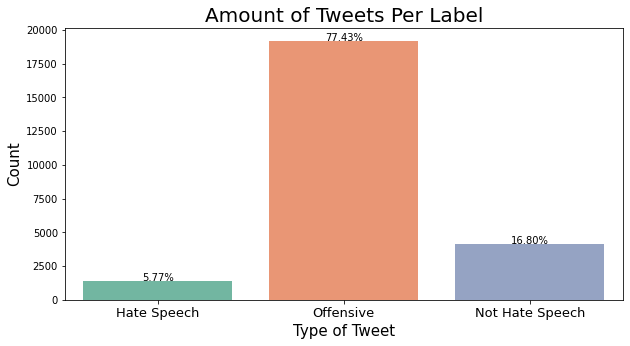

In [5]:
plt.figure(figsize = (10,5))
ax = sns.countplot(df['class'], palette='Set2')

ax.set_title('Amount of Tweets Per Label',fontsize = 20)
ax.set_xlabel('Type of Tweet',fontsize = 15)
ax.set_ylabel('Count',fontsize = 15)
ax.set_xticklabels(['Hate Speech','Offensive', 'Not Hate Speech'],fontsize = 13)

total = float(len(df)) # one person per row 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total * 100) + '%',
            ha="center") 

plt.savefig(r'C:\Users\acer\Desktop\Projet\visualizations\cleaned_class_imbalance.png', bbox_inches = "tight", pad_inches=.5)

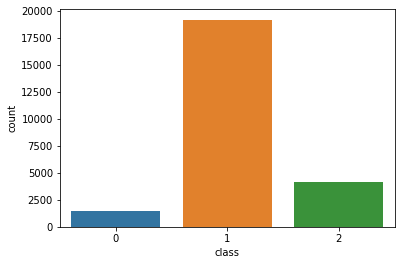

In [6]:
sns.countplot(df['class'])
plt.show()

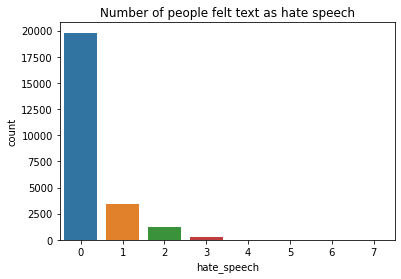

In [7]:
sns.countplot(df['hate_speech'])
plt.title('Number of people felt text as hate speech')
plt.show()

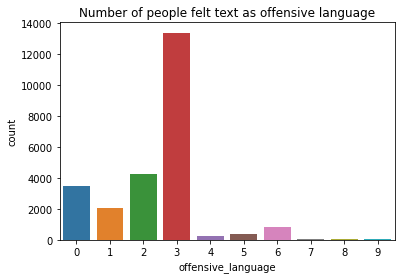

In [8]:
sns.countplot(df['offensive_language'])
plt.title('Number of people felt text as offensive language')
plt.show()

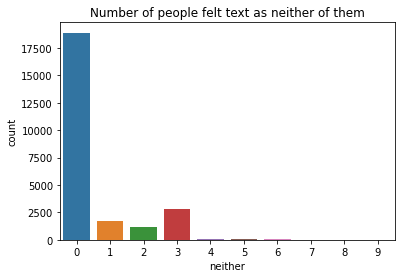

In [9]:
sns.countplot(df['neither'])
plt.title('Number of people felt text as neither of them')
plt.show()

In [10]:
def plot_dist(data):
    
    fig,ax = plt.subplots(1,2,figsize=(15,5))
    sns.distplot(data,ax=ax[0])
    sns.boxplot(data,ax=ax[1])
    plt.show()

In [11]:
# number of words
df['Number of words'] = df['tweet'].apply(lambda x: len(x.split(' ')))

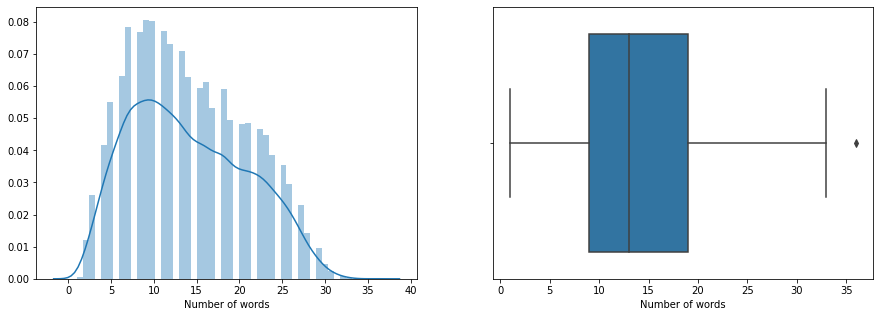

In [12]:
plot_dist(df['Number of words']);

In [13]:
# average word length
df['avg_word_len'] = df['tweet'].apply(lambda x: np.mean([len(c) for c in  x.split(' ')]))

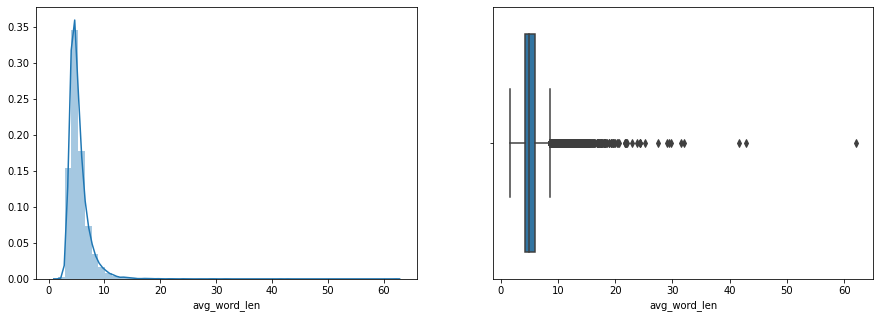

In [14]:
plot_dist(df['avg_word_len']);

In [15]:
# number of stopwords
df['Number of stop words'] = df['tweet'].apply(lambda x: len([c for c in x.split(' ') if c in stopwords]))

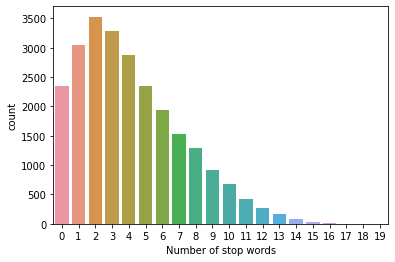

In [16]:
sns.countplot(df['Number of stop words'])
plt.show()

In [17]:
# number of character count
df['Number of char'] = df['tweet'].apply(lambda x: len(x))

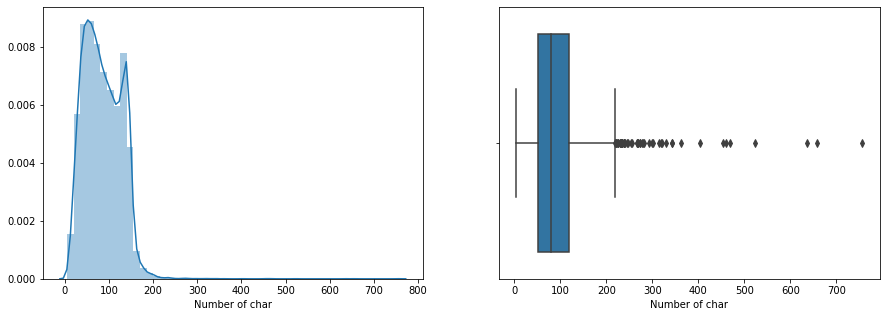

In [18]:
plot_dist(df['Number of char']);

In [19]:
# number of unique
df['Number of unique words'] = df['tweet'].apply(lambda x: len(set(x.split(' '))))

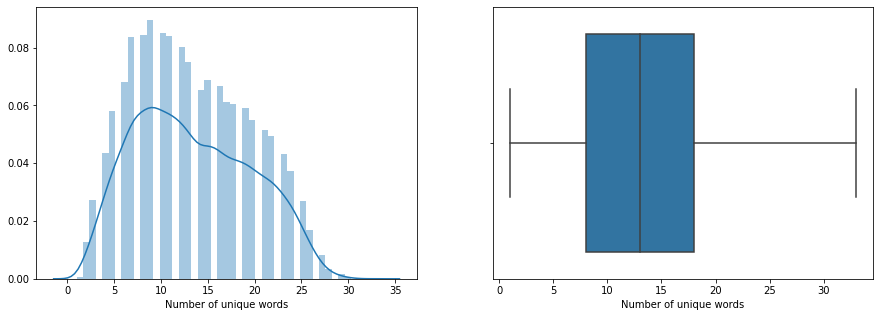

In [20]:
plot_dist(df['Number of unique words']);

In [21]:
# number of urls
df['Number of urls'] = df['tweet'].apply(lambda x: len(re.findall('https?',x)))

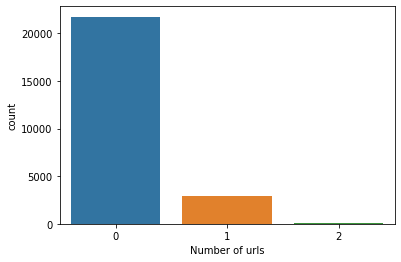

In [22]:
sns.countplot(df['Number of urls'])
plt.show()

In [23]:
# number of emoticons
df['Number of emoticons'] = df['tweet'].apply(lambda x: len(re.findall('&#[0-9]+;',x)))

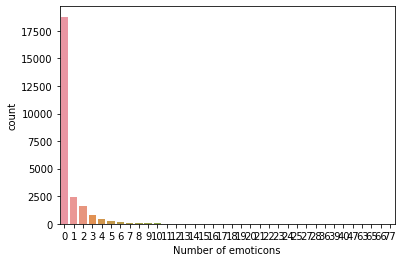

In [24]:
sns.countplot(df['Number of emoticons'])
plt.show()

In [25]:
# number of punctuations
df['Number of punctuations'] = df['tweet'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

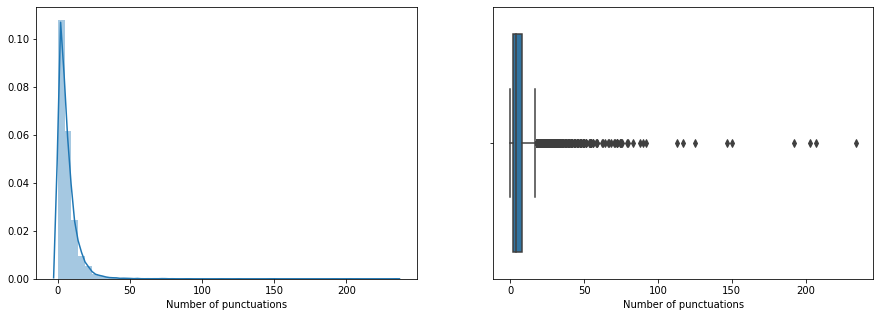

In [26]:
plot_dist(df['Number of punctuations']);

In [27]:
# number of mentions
df['Number of mentions'] = df['tweet'].apply(lambda x: len(re.findall('@',x)))

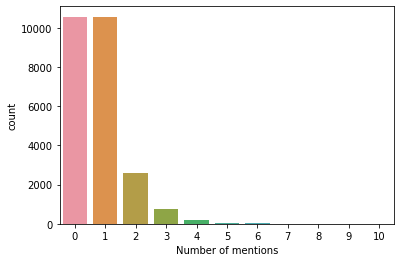

In [28]:
sns.countplot(df['Number of mentions'])
plt.show()

In [29]:
# number of hastags
df['Number of hashtags'] = df['tweet'].apply(lambda x: len(re.findall('#',x)))

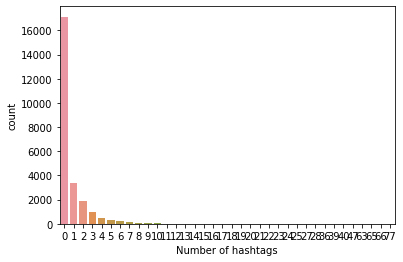

In [30]:
sns.countplot(df['Number of hashtags'])
plt.show()

## Contractions
Sure, you can write a long list of regular expressions to expand contractions in your text data (i.e. don’t → do not; can’t → cannot; haven’t → have not). But why not save your efforts and leverage a Python library to do the heavy lifting for you?
Contractions is an easy-to-use library that will expand both common English contractions and slang. It is fast, efficient, and handles most edge cases, such as missing apostrophes.

In [40]:
# # df["expanded_words"]=df['tweet'].apply(lambda x: [contractions.fix(word) for word in x.split()])
# df["expanded_words"]=df['tweet'].apply(lambda x: [contractions.fix(word) for word in x.split()])

AttributeError: 'dict' object has no attribute 'fix'

In [ ]:
# df["expanded_words"].head(10)

In [ ]:
# sns.countplot(df["expanded_words"])
# # plt.show()

# Gibberish-Detector
The primary purpose of this low-code library is to detect gibberish (or unintelligible words). It uses a model that is trained on a large corpus of English words.

1. Download the training corpus called big.txt from [https://github.com/rrenaud/Gibberish-Detector/blob/master/big.txt]
2. Open your CLI and cd over to the directory in which big.txt is located
3. Run the following: gibberish-detector train .\big.txt > gibberish-detector.model
    
A file called gibberish-detector.model will be created in the current directory.

In [ ]:
# %%time
# from gibberish_detector import detector
# # load the gibberish detection model
# Detector = detector.create_from_model(r'C:\Users\acer\Desktop\Projet\src\gibberish-detector.model')
# df["gibberish_words"]=df['tweet'].apply(lambda x: [Detector.is_gibberish(word) for word in x.split()])

In [ ]:
# sns.countplot(df["gibberish_words"])
# plt.show()

# NLPAug

what is data augmentation? It is any technique that expands the size of a training set by adding slightly modified copies of the existing data. Data augmentation is commonly used when the existing data is either limited in diversity or imbalanced. For computer vision problems, augmentation is used to create new samples by cropping, rotating, and changing the brightness of images. With numerical data, synthesized instances can be created by using clustering techniques.

In [ ]:
# pip install nlpaug

In [41]:
import nlpaug.augmenter.word as naw
# main parameters to adjust
ACTION = 'substitute' # or use 'insert'
TOP_K = 15 # randomly draw from top 15 suggested words
AUG_P = 0.40 # augment 40% of words within text
aug_bert = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased', 
    action=ACTION, 
    top_k=TOP_K,
    aug_p=AUG_P
    )
text = """
Come into town with me today to buy food!
"""
augmented_text = aug_bert.augment(text, n=3) # n: num. of outputs
print(augmented_text)

['come into town get me tomorrow to borrow clothes!', 'come from town with me where i collect food!', 'come about town after me today then order food!']


In [ ]:
%%time
df["agumented_word"]=df['tweet'].apply(lambda x: [aug_bert.augment(word) for word in df['tweet']])

In [ ]:
plt.figure(figsize = (10,5))
ax = sns.countplot(df["agumented_word"], palette='Set3')

ax.set_title('Argumented Words Per Label',fontsize = 20)
ax.set_xlabel('Type of Tweet',fontsize = 15)
ax.set_ylabel('Count',fontsize = 15)
ax.set_xticklabels(['Hate Speech','Offensive', 'Not Hate Speech'],fontsize = 13)

total = float(len(df)) # one person per row 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total * 100) + '%',
            ha="center") 

plt.savefig(r'C:\Users\acer\Desktop\Projet\visualizations\balanced_aug_data.png', bbox_inches = "tight", pad_inches=.5)

In [ ]:
# sns.countplot(df["agumented_word"])
# plt.show()
df["agumented_word"].head(10)

In [ ]:
df["labels"] = df["class"].map({0: "Hate Speech", 
                                    1: "Offensive Language", 
                                    2: "No Hate and Offensive"
                                    3: "Gribbish Detected"})
print(df.head())

In [ ]:
df['label'] = df['class']

In [ ]:
df.label.unique()

In [ ]:
plt.figure(figsize = (10,5))
ax = sns.countplot(df['label'], palette='Set2')

ax.set_title('Amount of Tweets Per Label',fontsize = 20)
ax.set_xlabel('Type of Tweet',fontsize = 15)
ax.set_ylabel('Count',fontsize = 15)
ax.set_xticklabels(['Hate Speech','Offensive', 'Not Hate Speech'],fontsize = 13)

total = float(len(df)) # one person per row 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total * 100) + '%',
            ha="center") 

plt.savefig(r'C:\Users\acer\Desktop\Projet\visualizations\cleaned_class_imbalance.png', bbox_inches = "tight", facecolor='w',pad_inches=.5)

In [ ]:
raw_df = df.copy()
raw_df.head()

In [ ]:
# pickling the raw tweets for later EDA
raw_df.to_pickle(r"C:\Users\acer\Desktop\Projet\pickel\raw_tweets_df.pkl")

In [ ]:
df = pd.DataFrame(raw_df)
  
# saving the dataframe
df.to_csv(r"C:\Users\acer\Desktop\Projet\src\raw_counts.csv", index=False)

# Creating new `clean_df` with renamed columns

In [ ]:
# function to clean all data
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    # make text lowercase
    text = text.lower()
    # removing text within brackets
    text = re.sub('\[.*?\]', '', text)
    # removing text within parentheses
    text = re.sub('\(.*?\)', '', text)
    # removing numbers
    text = re.sub('\w*\d\w*', '', text)
    # if there's more than 1 whitespace, then make it just 1
    text = re.sub('\s+', ' ', text)
    # if there's a new line, then make it a whitespace
    text = re.sub('\n', ' ', text)
    # removing any quotes
    text = re.sub('\"+', '', text)
    # removing &amp;
    text = re.sub('(\&amp\;)', '', text)
    # removing any usernames
    text = re.sub('(@[^\s]+)', '', text)
    # removing any hashtags
    text = re.sub('(#[^\s]+)', '', text)
    # remove `rt` for retweet
    text = re.sub('(rt)', '', text)
    # string.punctuation is a string of all punctuation marks
    # so this gets rid of all punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # getting rid of `httptco`
    text = re.sub('(httptco)', '', text)
#     tweet_df["gibberish_words"]=tweet_df['clean_tweets'].apply(lambda x: [Detector.is_gibberish(word) for word in x.split()])
    

    return text

round1 = lambda x: clean_text_round1(x)

In [ ]:
# appling data cleaning function to `tweet` column
df['clean_tweets'] = df['tweet'].apply(round1)
clean_tweets = df['clean_tweets'] 
# checking that it worked
clean_tweets.head(5)

In [ ]:
df = pd.DataFrame(df)

# saving the dataframe
df.to_csv(r'C:\Users\acer\Desktop\Projet\src\round1_clean.csv', index=False)

In [ ]:
# checking for missing values
df.isnull().sum()

# Pickling `clean_df` for later use
If there needs to be further data cleaning or preprocessing, that will be done in other notebooks

In [ ]:
df.to_pickle(r"C:\Users\acer\Desktop\Projet\pickel\clean_df.pkl")

# Exploratory Data Analysis

In [ ]:
# loading in clean_df
df = pd.read_pickle(r"C:\Users\acer\Desktop\Projet\pickel\clean_df.pkl")

In [ ]:
df.head(10)

# Censoring Words

In [ ]:
replacements = { 'bitch':'b**ch', 'bitches':'b**ches', 'nigga':'n***a', 'nigger':'ni**er', 'ass':'a**', 'hoe':'h**', 'hoes':'h**s', 'faggot':'fa***t', 'faggots':'fa***ts', 'fuck':'f**k','fucking':'f**king', 'pussy':'p**sy', 'fag':'f**', 'shit':'sh*t' }

for k, v in replacements.items():
    df['clean_tweets'] = df['clean_tweets'].str.replace(k, v)
# checking that worked
df.head(5)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline
plt.style.use('bmh')
# NLP libraries
import nltk
from sklearn.feature_extraction import text 
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.naive_bayes import MultinomialNB

# Most Frequent Words for Each Classification

In [ ]:
# creating new dfs for each classification
df_freq_hate = df[df['label']==0]
df_freq_offensive = df[df['label']==1]
df_freq_neither = df[df['label']==2]

In [ ]:
# pulling out the text data for cleaned tweets
data_hate = df_freq_hate['clean_tweets']
data_offensive = df_freq_offensive['clean_tweets']
data_neither = df_freq_neither['clean_tweets']

In [ ]:
# function to tokenize tweets and remove stop words with NLTK built-in library
stop_words = set(stopwords.words('english'))
def process_tweet(text):
    tokens = nltk.word_tokenize(text)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stop_words]
    return stopwords_removed 

In [ ]:
# creating lists for processed hate & not hate data
process_hate = list(map(process_tweet, data_hate))
process_offensive = list(map(process_tweet, data_offensive))
process_neither = list(map(process_tweet, data_neither))

In [ ]:
# exact amount of hate speech
total_vocab_hate = set()
for comment in process_hate:
    total_vocab_hate.update(comment)
len(total_vocab_hate)

In [ ]:
# exact amount of neither
total_vocab_neither = set()
for comment in process_neither:
    total_vocab_neither.update(comment)
len(total_vocab_neither)

In [ ]:
# exact amount of offensive
total_vocab_offensive = set()
for comment in process_offensive:
    total_vocab_offensive.update(comment)
len(total_vocab_offensive)

## Most Common Words in Each Category

In [ ]:
flat_hate = [item for sublist in process_hate for item in sublist]
flat_neither = [item for sublist in process_neither for item in sublist]
flat_offensive = [item for sublist in process_offensive for item in sublist]

In [ ]:
hate_freq = FreqDist(flat_hate)
offensive_freq = FreqDist(flat_offensive)
neither_freq = FreqDist(flat_neither)

In [ ]:
# Top 20 Hate Speech words:
hate_freq.most_common(20)

In [ ]:
# Top 20 offensive words:
offensive_freq.most_common(20)

In [ ]:
# Top 20 neither words:
neither_freq.most_common(20)

## Normalizing Word Frequencies

In [ ]:
hate_total_word_count = sum(hate_freq.values())
hate_top_25 = hate_freq.most_common(25)
print("Hate Word \t Normalized Frequency")
print()
for word in hate_top_25:
    normalized_frequency = word[1]/hate_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

In [ ]:
offensive_word_count = sum(offensive_freq.values())
offensive_top_25 = offensive_freq.most_common(25)
print("Offensive Word \t Normalized Frequency")
print()
for word in offensive_top_25:
    normalized_frequency = word[1]/offensive_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

In [ ]:
neither_word_count = sum(neither_freq.values())
neither_top_25 = neither_freq.most_common(25)
print("Neither Word \t Normalized Frequency")
print()
for word in offensive_top_25:
    normalized_frequency = word[1]/neither_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

### Visualizing Top Word Percentages

In [ ]:
# create counts of hate and not hate with values and words
hate_bar_counts = [x[1] for x in hate_freq.most_common(20)]
hate_bar_words = [x[0] for x in hate_freq.most_common(20)]

offensive_bar_counts = [x[1] for x in offensive_freq.most_common(20)]
offensive_bar_words = [x[0] for x in offensive_freq.most_common(20)]

neither_bar_counts = [x[1] for x in neither_freq.most_common(20)]
neither_bar_words = [x[0] for x in neither_freq.most_common(20)]

In [ ]:
# set the color of the bar graphs
color = cm.magma(np.linspace(.4,.8, 30))

In [ ]:
new_figure = plt.figure(figsize=(30, 15))

ax = new_figure.add_subplot(121)
ax.invert_yaxis()

ax2 = new_figure.add_subplot(223)
ax2.invert_yaxis()

ax3 = new_figure.add_subplot(122)
ax3.invert_yaxis()

# generating a bar chart on each axes
ax.barh(hate_bar_words, hate_bar_counts, color=color)
ax2.barh(offensive_bar_words, offensive_bar_counts, color=color)
ax3.barh(neither_bar_words, neither_bar_counts, color=color)


ax.title.set_text('Hate Speech')
ax2.title.set_text('Offensive')
ax3.title.set_text('Neither Speech')

for ax in new_figure.axes:
    plt.sca(ax)
    plt.xticks(rotation=120, fontsize=14)
    plt.xlabel("Word Count")
    plt.yticks(fontsize=14)
plt.tight_layout(pad=2)

new_figure.suptitle('Top 20 Most Frequent Words per Label', fontsize=16)

plt.savefig(r'C:\Users\acer\Desktop\Projet\visualizations\label_word_count_y.png',facecolor='w', pad_inches=2)
plt.show()

Linguistically, it's important to note that the difference between hate speech and offensive lanugage often comes down to how it targets marginalized communities, often in threatening ways. 

For instance, we can notice from this figure that Hate Speech typically contains the N-word with the hard 'R'. The use of this slur indicates far more malicious intent, which goes beyond possibly using the word as slang.

Examples like that demonstratee the neuances of English slang and the fine line beteween Hate Speech and offensive language. 

# What Words are Only in Hate Speech?

The purpose of this is to check whether the words unique to the "Hate Speech" label are threatening or especially derogatory.

In [ ]:
def returnNotMatches(a, b, c):
    return [x for x in a if x not in [b,c]]
            
returnNotMatches(flat_hate, flat_neither,flat_offensive)

In [ ]:
def returnNotMatches(a, b, c):
    return [x for x in b if x not in [a,c]]
            
returnNotMatches(flat_hate, flat_neither,flat_offensive)

In [ ]:
def returnNotMatches(a, b, c):
    return [x for x in c if x not in [a,b]]
            
returnNotMatches(flat_hate, flat_neither,flat_offensive)

## Visualizing Unique Words with Venn Diagram

In [ ]:
import matplotlib_venn as venn
from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles
import matplotlib.pyplot as plt

In [ ]:
venn3([set(flat_hate), set(flat_neither), set(flat_offensive)], set_labels = ('Hate Speech', 'Not Hate Speech','Offensive Speech'))
plt.title('Comparison of Unique Words in Each Corpus Label')
plt.savefig(r'C:\Users\acer\Desktop\Projet\visualizations\word_venn.png', bbox_inches = "tight", pad_inches=.5, facecolor='w')

# Preprocessing Text Data

The purpose of this notebook is to conduct the preprocessing steps that are necessary for text data in NLP. This includes tokenizing, removing stop words, vectorizing, etc.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns; sns.set()
%matplotlib inline
# packages for NLP preprocessing
import nltk
from sklearn.feature_extraction import text 
from nltk.stem import WordNetLemmatizer 
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.collocations import *
import pickle

In [ ]:
# this is our corpus
clean_df = pd.read_pickle(r"C:\Users\acer\Desktop\Projet\pickel\clean_df.pkl")
clean_df.head()

# Creating `tweet_df` with only cleaned tweets column

In [ ]:
tweet_df = clean_df[['clean_tweets', 'label']].copy()

In [ ]:
tweet_df.head()